In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
import os
import shutil
from sklearn.model_selection import train_test_split

In [55]:
from torchvision import transforms

# Define data transformations for data augmentation and normalization
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),  # Randomly crop and resize the image to 224x224
        transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Randomly adjust brightness, contrast, saturation, and hue
        transforms.RandomRotation(15),  # Randomly rotate the image by up to 15 degrees
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Randomly translate the image horizontally and vertically
        transforms.RandomPerspective(distortion_scale=0.2, p=0.5),  # Randomly apply perspective transformation
        transforms.ToTensor(),  # Convert the image to a tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize with ImageNet mean and standard deviation
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),  # Resize the image to 256x256
        transforms.CenterCrop(224),  # Crop the center 224x224 region of the image
        transforms.ToTensor(),  # Convert the image to a tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize with ImageNet mean and standard deviation
    ]),
}


In [56]:
data_dir = '/content/drive/MyDrive/archive/'

#Give path to where you want the train and validation dataset to be
train_path = "/content/drive/MyDrive/archive/train"
val_path = "/content/drive/MyDrive/archive/val"

#To check if they exist or create new folders
os.makedirs(train_path, exist_ok=True)
os.makedirs(val_path, exist_ok=True)





In [57]:
class_folders = [folder for folder in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, folder))]
len(class_folders)

9

In [19]:
for class_folder in class_folders:
    class_path = os.path.join(data_dir, class_folder)

    # Get the list of images in the class folder
    images = [img for img in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, img))]

    # Split the images into train and validation sets
    train_images, val_images = train_test_split(images, test_size=0.2, random_state=42)

    # Create destination paths for train and validation images
    train_dest = os.path.join(train_path, class_folder)
    val_dest = os.path.join(val_path, class_folder)

    # Create train and validation class folders if they don't exist
    os.makedirs(train_dest, exist_ok=True)
    os.makedirs(val_dest, exist_ok=True)

    # Move images to the respective train and validation folders
    for img in train_images:
        src_path = os.path.join(class_path, img)
        dest_path = os.path.join(train_dest, img)
        shutil.copy(src_path, dest_path)

    for img in val_images:
        src_path = os.path.join(class_path, img)
        dest_path = os.path.join(val_dest, img)
        shutil.copy(src_path, dest_path)

In [59]:
# Create data loaders
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
#image_datasets

In [60]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16, shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
print(dataset_sizes)

class_names = image_datasets['train'].classes
class_names

{'train': 359, 'val': 92}


['Black Scurf',
 'Blackleg',
 'Common Scab',
 'Dry Rot',
 'Healthy Potatoes',
 'Miscellaneous',
 'Pink Rot']

In [61]:
# Load the pre-trained ResNet-18 model
model = models.resnet18(pretrained=True)

# Freeze all layers except the final classification layer
for name, param in model.named_parameters():
    if "fc" in name:  # Unfreeze the final classification layer
        param.requires_grad = True
    else:
        param.requires_grad = False

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)  # Use all parameters


# Move the model to the GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [62]:
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

print("Training complete!")

train Loss: 4.1628 Acc: 0.1727
val Loss: 1.5205 Acc: 0.5435
train Loss: 1.8244 Acc: 0.4373
val Loss: 1.6779 Acc: 0.6087
train Loss: 1.6010 Acc: 0.5404
val Loss: 1.6864 Acc: 0.5870
train Loss: 1.4907 Acc: 0.5571
val Loss: 1.3658 Acc: 0.6304
train Loss: 1.6052 Acc: 0.5376
val Loss: 1.5782 Acc: 0.6196
train Loss: 1.8126 Acc: 0.5655
val Loss: 1.8283 Acc: 0.6087
train Loss: 1.4958 Acc: 0.5877
val Loss: 1.4266 Acc: 0.6522
train Loss: 1.3117 Acc: 0.6212
val Loss: 1.6369 Acc: 0.5652
train Loss: 1.3425 Acc: 0.6128
val Loss: 1.7530 Acc: 0.6630
train Loss: 1.6604 Acc: 0.5794
val Loss: 1.0456 Acc: 0.7283
Training complete!


In [63]:
torch.save(model.state_dict(), 'potato_classification_model.pth')

In [64]:
import torch
from torchvision import models, transforms
from PIL import Image

# Load the saved model
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 1000)  # Adjust to match the original model's output units
model.load_state_dict(torch.load('potato_classification_model.pth'))
model.eval()

# Create a new model with the correct final layer
new_model = models.resnet18(pretrained=True)
new_model.fc = nn.Linear(new_model.fc.in_features, 7)  # Adjust to match the desired output units

# Copy the weights and biases from the loaded model to the new model
new_model.fc.weight.data = model.fc.weight.data[0:7]  # Copy only the first 2 output units
new_model.fc.bias.data = model.fc.bias.data[0:7]

In [68]:
# Load and preprocess the unseen image
image_path = 'test.jpg'  # Replace with the path to your image
image = Image.open(image_path)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)  # Add a batch dimension

In [69]:
# Perform inference
with torch.no_grad():
    output = model(input_batch)

# Get the predicted class
_, predicted_class = output.max(1)

# Map the predicted class to the class name
class_names = ['Pink Rot', 'Miscellaneous','Healthy Potatoes','Dry Rot','Common Scab', 'Blackleg','Black Scurf']  # Make sure these class names match your training data
predicted_class_name = class_names[predicted_class.item()]

print(f'The predicted class is: {predicted_class_name}')

The predicted class is: Common Scab


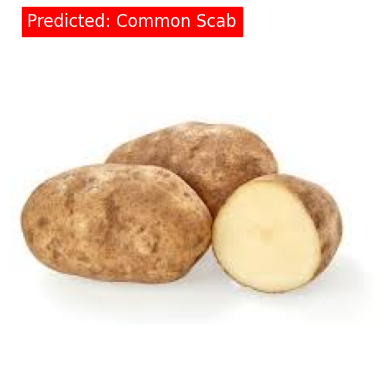

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Display the image with the predicted class name
image = np.array(image)
plt.imshow(image)
plt.axis('off')
plt.text(10, 10, f'Predicted: {predicted_class_name}', fontsize=12, color='white', backgroundcolor='red')
plt.show()